In [ ]:
# ------------------------------------------ IMPORTS --------------------------------------------------------------------------------------#
import os
import random
import sys
import numpy as np
from scipy.spatial import distance_matrix
import math
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))
from epstein_civil_violence.model import EpsteinCivilViolence

In [ ]:
# -------------------- HELPER FUNCTIONS -----------------------------------------------------------------------------------------------------#
def ripley_l_function(points, radius, area=None):
    """
    Compute Ripley's K-function for a set of 2D points.
    """
    points = np.asarray(points)
    N = len(points)
    if N < 2:
        raise ValueError("Need at least 2 points.")

    if area is None:
        xmin, ymin = points.min(axis=0)
        xmax, ymax = points.max(axis=0)
        area = (xmax - xmin) * (ymax - ymin)

    lambda_density = (N / area)**(-1)
    dists = distance_matrix(points, points)
    np.fill_diagonal(dists, np.inf)

    count = np.sum(dists <= radius)
    L = math.sqrt(((lambda_density*(count/N))/math.pi))

    return L


def preprocess_data(model_out):
    """
    Store aggregated model output data.
    """
    outburst_steps = model_out[model_out["active"] > 50].index.tolist()
    actives = model_out[model_out["active"] > 50]["active"].tolist()

    n_steps = len(model_out["citizen"])
    n_people = len(model_out["citizen"][0])

    # Initialize lists
    legitimacies = []
    grievances = []
    positions = []
    steps = [i for i in range(n_steps)]

    for step in range(n_steps):
        
        # Intiallize sublists
        legitimacies.append([])
        grievances.append([])
        positions.append([])

        # Fill list with citizen data
        for person in range(n_people):
            legitimacies[step].append(model_out["citizen"][step][person][2])
            grievances[step].append(model_out["citizen"][step][person][3])
            positions[step].append((model_out["citizen"][step][person][0], model_out["citizen"][step][person][1]))

        # Aggregate over all the different agents    
        ripley_indexes = [ripley_l_function(np.array(item), [20]) for item in positions]
        average_grievances = [np.mean(item) for item in grievances]
        average_legitimacies = [np.mean(item) for item in legitimacies]

    # legitimacies = [[model_out["citizen"][step][person][2] for person in range(n_people)] for step in range(n_steps)]
    # grievances = [[model_out["citizen"][step][person][3] for person in range(n_people)] for step in range(n_steps)]
    # positions = [np.array([(model_out["citizen"][step][person][0], model_out["citizen"][step][person][1]) for person in range(n_people)]) for step in range(n_steps)]
    # ripley_indexes = [ripley_l_function(item, [20]) for item in positions]

    outburst_data = pd.DataFrame({"step": outburst_steps, "actives": actives})

    citizen_data = {"steps": steps, "legitimacies": average_legitimacies, "grievances": average_grievances, "ripley_indexes": ripley_indexes}
    
    return outburst_data, citizen_data

def calculate_interval_and_sizes(activity):
    intervals = []
    sizes = []
    current_size = 0
    if not activity.empty:
        old_item = activity.iloc[0]
        for i in tqdm(range(1, activity.shape[0])):
            item = activity.iloc[i]
            interval = item[0] - old_item[0]

            if interval != 1:  # A new revolution has started

                # Information is added about previous revolution
                intervals.append(int(interval))
                current_size += item[1]
                sizes.append(int(current_size))
                current_size = 0

            else:  # The revolution is still going

                current_size += item[1]
            old_item = item
    return intervals, sizes



  4%|▍         | 2/50 [12:18<4:54:49, 368.53s/it]C:\Users\frede\AppData\Local\Temp\ipykernel_23180\3697592585.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  interval = item[0] - old_item[0]
C:\Users\frede\AppData\Local\Temp\ipykernel_23180\3697592585.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_size += item[1]
100%|██████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]/50 [18:01<4:39:35, 356.92s/it]
100%|██████████| 2/2 [00:00<?, ?it/s]31, 349.42s/it]
0it [00:00, ?it/s]7/50 [3:39:17<1:16:19, 352.31s/it]
100%|██████████| 2/2 [00:00<00:00, 2017.95it/s]it]  
0it [00:00, ?it/s]3/50 [4:14:12<40:23, 346.

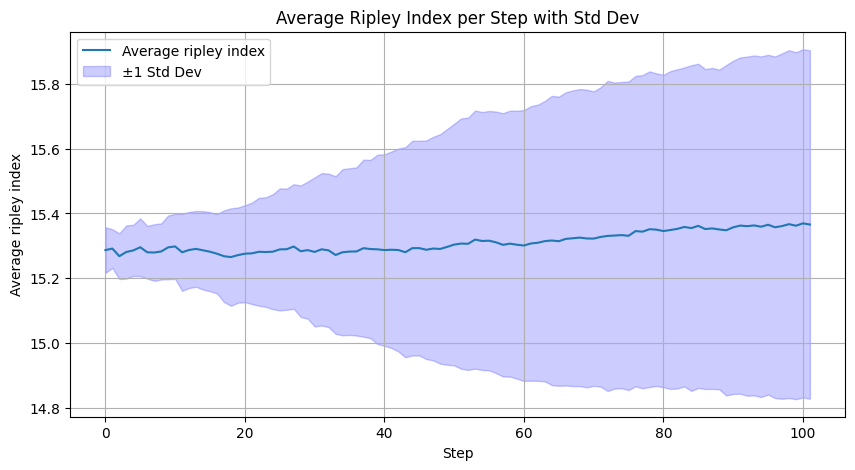

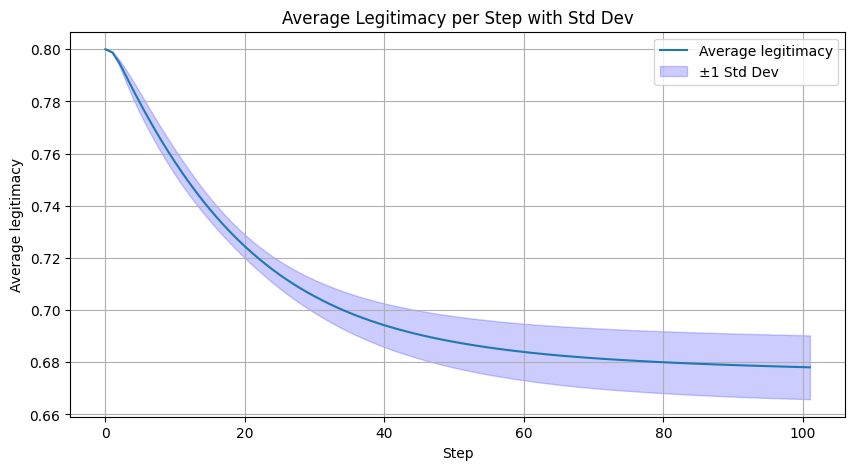

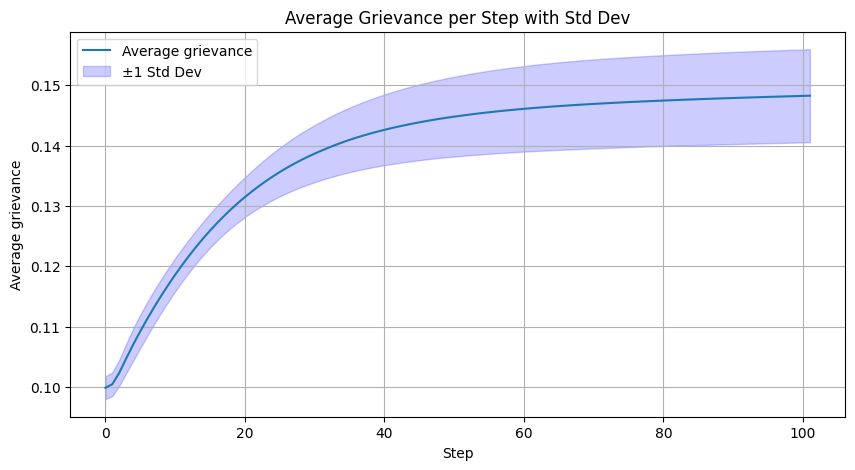

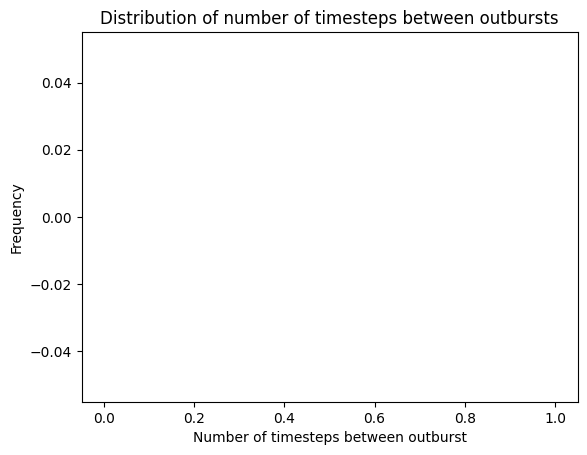

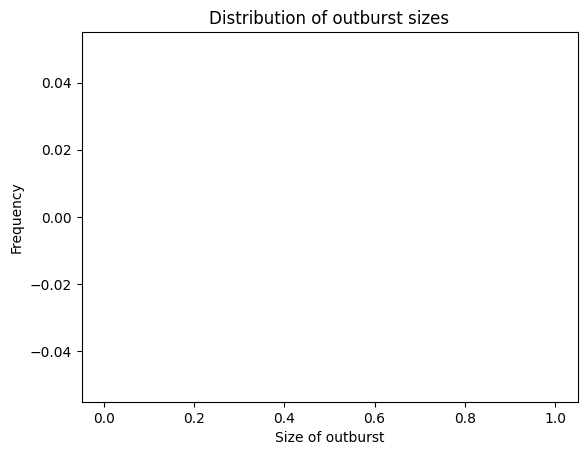

100%|██████████| 3/3 [00:00<?, ?it/s] 350.38s/it]
0it [00:00, ?it/s]/50 [17:31<4:33:16, 348.87s/it]
100%|██████████| 2/2 [00:00<?, ?it/s]42, 349.04s/it]
0it [00:00, ?it/s]2/50 [2:08:18<2:43:31, 350.43s/it]
100%|██████████| 50/50 [4:53:15<00:00, 351.90s/it]


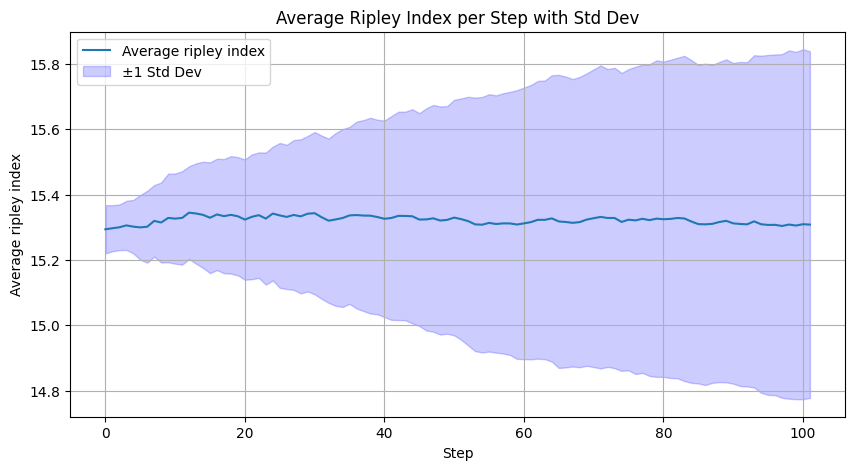

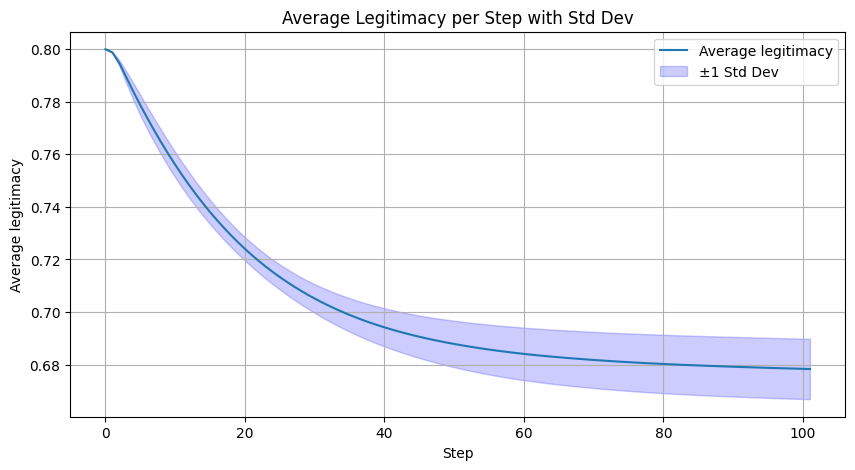

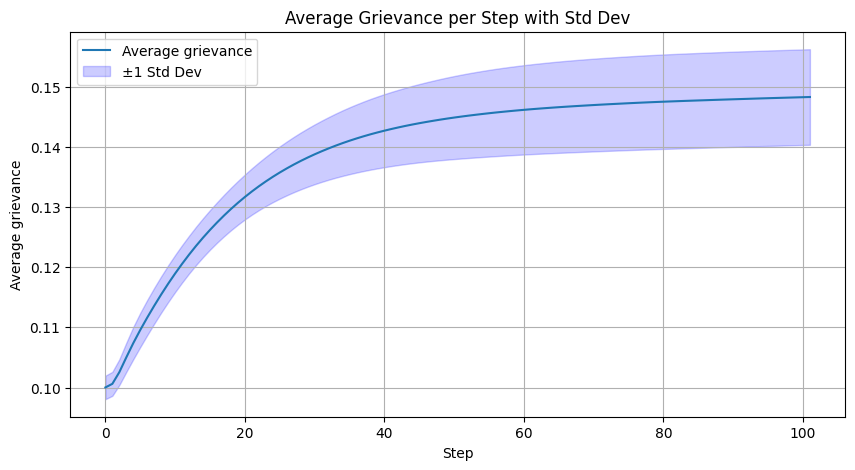

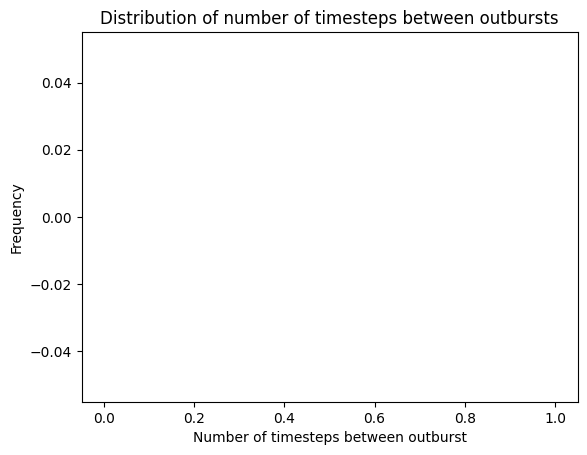

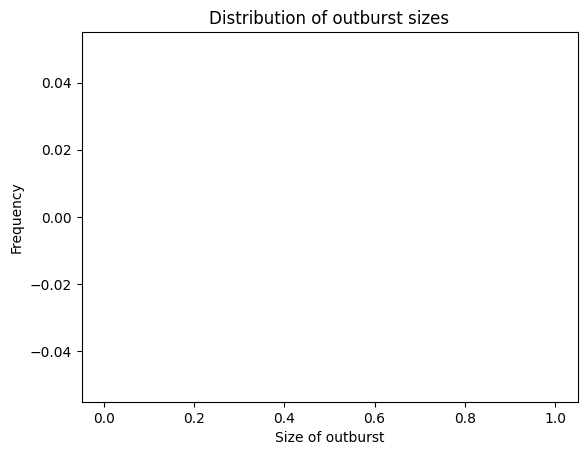

In [43]:
# ----------------------------------- BASIC STATISTICS -----------------------------------------------------------------------------------------
def sample_runs(
    n_runs=100,
    height=40,
    width=40,
    citizen_density=0.7,
    cop_density=0.074,
    citizen_vision=7,
    cop_vision=7,
    legitimacy=0.8,
    max_jail_term=1000,
    max_iters=100,
):
    intervals = []
    sizes = []
    data = {"steps": [], "ripley_indexes": [], "legitimacies": [], "grievances": [] }

    for _ in tqdm(range(n_runs)):
        # Run the model
        seed = random.randint(1, 10000)
        model = EpsteinCivilViolence(
            height=height,
            width=width,
            citizen_density=citizen_density,
            cop_density=cop_density,
            citizen_vision=citizen_vision,
            cop_vision=cop_vision,
            legitimacy=legitimacy,
            max_jail_term=max_jail_term,
            max_iters=max_iters,
            seed=seed,
        )
        model.run_model()

        # Get statistics
        model_out = model.datacollector.get_model_vars_dataframe()
        outburst_data, citizen_data = preprocess_data(model_out)
        interval, size = calculate_interval_and_sizes(outburst_data)
        intervals += interval
        sizes += size
        data["steps"].extend(citizen_data["steps"])
        data["ripley_indexes"].extend(citizen_data["ripley_indexes"])
        data["legitimacies"].extend(citizen_data["legitimacies"])
        data["grievances"].extend(citizen_data["grievances"])

    df = pd.DataFrame(data)

    # Plot ripley index
    grouped_ripley = df.groupby('steps')['ripley_indexes']
    means_ripley = grouped_ripley.mean()
    stds_ripley = grouped_ripley.std()

    plt.figure(figsize=(10, 5))
    plt.plot(means_ripley.index, means_ripley.values, label='Average ripley index')
    plt.fill_between(means_ripley.index, means_ripley - stds_ripley, means_ripley + stds_ripley, color='blue', alpha=0.2, label='±1 Std Dev')

    plt.xlabel('Step')
    plt.ylabel('Average ripley index')
    plt.title('Average Ripley Index per Step with Std Dev')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot legitimacy
    grouped_l = df.groupby('steps')['legitimacies']
    means_l = grouped_l.mean()
    stds_l = grouped_l.std()

    plt.figure(figsize=(10, 5))
    plt.plot(means_l.index, means_l.values, label='Average legitimacy')
    plt.fill_between(means_l.index, means_l - stds_l, means_l + stds_l, color='blue', alpha=0.2, label='±1 Std Dev')

    plt.xlabel('Step')
    plt.ylabel('Average legitimacy')
    plt.title('Average Legitimacy per Step with Std Dev')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot legitimacy
    grouped_g = df.groupby('steps')['grievances']
    means_g = grouped_g.mean()
    stds_g = grouped_g.std()

    plt.figure(figsize=(10, 5))
    plt.plot(means_g.index, means_g.values, label='Average grievance')
    plt.fill_between(means_g.index, means_g - stds_g, means_g + stds_g, color='blue', alpha=0.2, label='±1 Std Dev')

    plt.xlabel('Step')
    plt.ylabel('Average grievance')
    plt.title('Average Grievance per Step with Std Dev')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot intervals
    plt.hist(intervals, bins=5)
    plt.xlabel('Number of timesteps between outburst')
    plt.ylabel('Frequency')
    plt.title('Distribution of number of timesteps between outbursts')
    plt.show()

    # Plot sizese
    plt.hist(sizes, bins=50)
    plt.xlabel('Size of outburst')
    plt.ylabel('Frequency')
    plt.title('Distribution of outburst sizes')
    plt.show()

    return means_ripley, stds_ripley, means_l, stds_l, means_g, stds_g, intervals, sizes


mr, sr, ml, sl, mg, sg, i, s = sample_runs(n_runs=50)
mr2, sr2, ml2, sl2, mg2, sg2, i2, s2 = sample_runs(n_runs=50)